<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/notebooks/practica_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Clase 4: Ajuste de funciones de distribución

## Introducción: Soluciones analíticas

En la clase de hoy vamos a ver cómo ajustar funciones de distribución. Es decir, encontrar la función de distribución posterior de los parámetros de un modelo de generación de datos, y luego hacer predicciones considerando la incertidumbre en los parámetros del modelo.

En la clase de hoy trabajaremos con soluciones analíticas de la función posterior y la predictiva, que utilizan distribuciones a priori no-informativas

En la clase siguiente veremos la solución numérica del mismo problema, que permitirá resolver mayor número de problemas y dará más flexibilidad a su vez.

##Ejemplo 1: Resistencia característica del hormigón elaborado en planta

Una planta hormigonera quiere realizar un control de calidad del hormigón, el cual vende como H-30 siguiendo los lineamientos del reglamento CIRSOC 201-2005 (${f^{\prime}}_{c}=30MPa$). El reglamento define a la resistencia característica como aquella que tiene una probablildad del 90% de ser superada.

En total se tienen 42 ensayos de probetas moldeadas con la misma dosificación. A partir de los datos, defina la resistencia característica del hormigón.

###PASO 1: Análisis Exploratorio de Datos

Primero, veamos que distribución parece gobernar la resistencia del hormigón (para la dosificación estudiada). Empecemos con la carga de datos y la elaboración de un histograma para ver qué modelo podríamos proponer. A su vez, la autocorrelación nos permite ver si los ensayos son eventos independientes.

In [1]:
import numpy as np
import scipy.stats as st
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import io

In [2]:
#Abrimos un archivo local, es decir, que ha sido descargado en su computadora
from google.colab import files
uploaded = files.upload()

Saving ProbetasHormigon.csv to ProbetasHormigon.csv


In [3]:
#Se crea un DataFrame
df_probetas = pd.read_csv(io.BytesIO(uploaded['ProbetasHormigon.csv']))
df_probetas.head()

,Ensayo,Resistencia (MPa),Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,1,33.3,NaN,NaN,NaN,NaN
1,2,37.4,NaN,NaN,NaN,NaN
2,3,36.5,NaN,NaN,NaN,NaN
3,4,32.3,NaN,NaN,NaN,NaN
4,5,37.4,NaN,NaN,NaN,NaN


In [5]:
# Momentos
muy = df_probetas['Resistencia (MPa)'].mean()
sy = df_probetas['Resistencia (MPa)'].std()
skewy = df_probetas['Resistencia (MPa)'].skew()
print('media',muy)
print('desvio',sy)
print('asimetria',skewy)

media 35.94761904761905
desvio 3.364610519643638
asimetria -0.17075957129985087


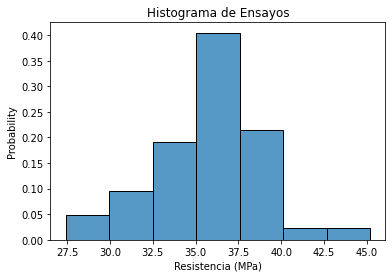

In [14]:
# Histograma con Seaborn
sns.histplot(data = df_probetas, x='Resistencia (MPa)', bins='sturges', stat='probability').set(title='Histograma de Ensayos')
plt.show()

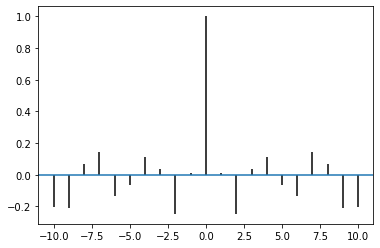

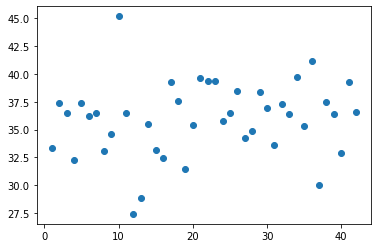

In [18]:
# Autocorrelación
plt.acorr( df_probetas['Resistencia (MPa)']-df_probetas['Resistencia (MPa)'].mean() );
plt.show()
plt.scatter( df_probetas['Ensayo'],df_probetas['Resistencia (MPa)'])

A falta de mejores ideas (les recomiendo jugar con el gráfico anterior, la forma es muy sensible al número de bins seleccionados) y viendo que las muestras parecen ser independientes, asumamos que la resistencia del hormigón sigue una distribución normal con parámetros $\mu$, $\sigma$ desconocidos.

###PASO 2: Definición del modelo

El modelo se define mediante la distribución de probabilidad de las obsrevaciones, y las distribuciones a priori de los parámetros.

A partir del análisis exploratorio, proponemos el siguiente modelo:

$$ y_i \sim N \left( \mu, \sigma^2 \right) $$

Con una distribución a priori no-informativa,

$$p(\mu,\sigma^{2}) \propto \left( \sigma^2 \right)^{-1}$$

Este modelo tiene solución analítica para la distribución posterior de los parámetros:

$$\mu | \mathbf{y} \sim t_{N-1}\left(\bar{y},s\sqrt{\frac{1}{N}}\right)$$

$$\sigma^{2} | \mathbf{y} \sim Inv-Gamma\left(\frac{N-1}{2},\frac{\left(N-1\right)s^{2}}{2}\right)$$

donde $\bar{y}$ es la media de las observaciones, $N$ el número de muestras y $s$ el desvío muestral.

###PASO 3: Inferencia estadística

Dada la sección anterior, ya tenemos todos los ingredientes para calcular la distribución a posterior de los parámetros:

In [19]:
# Numero de datos
N = len(df_probetas['Resistencia (MPa)'])
print('Numero de datos:',N)

# Valor medio
fmean = muy
print('Valor medio:',fmean,'MPa')

# Desvio (agregar ddof=1 para que sea el estimador del desvio)
fstd = sy
print('Desvio estandar:',fstd, 'MPa')

Numero de datos: 42
Valor medio: 35.94761904761905 MPa
Desvio estandar: 3.364610519643638 MPa


Y ya con esto se pueden calcular las distribuciones de $\mu|\mathbf{y}$ y $\sigma^{2}|\mathbf{y}$. Presten atención a cómo incluir los parámetros de las distribuciones descriptas arriba.

In [20]:
# Posterior marginal de mu
mu_post = st.t( N-1, loc=fmean, scale=fstd*np.sqrt(1/N))

# Posterior marginal de sigma2
s2_post = st.invgamma( (N-1)/2, loc=0, scale=(N-1)*fstd**2/2 )

Grafiquemos los resultados!

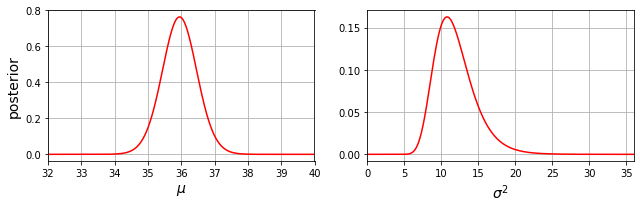

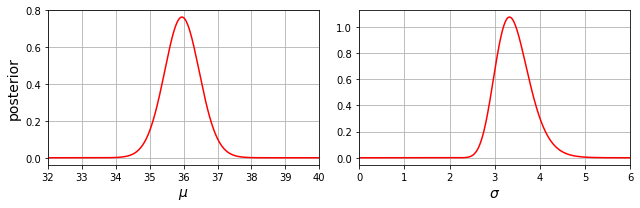

In [21]:
x=np.linspace(0,40,4001)

# Plot
fig, ax = plt.subplots( figsize=(9,3), nrows=1, ncols=2 )
ax[0].plot(x, mu_post.pdf(x), color='r')
ax[0].set_xlabel(r'$\mu$', fontsize=14)
ax[0].set_ylabel('posterior', fontsize=14)
ax[0].set_xlim([32,40])
ax[0].grid()

ax[1].plot(x**2, s2_post.pdf(x**2), color='r')
ax[1].set_xlabel(r'$\sigma^{2}$', fontsize=14)
#ax[1].set_ylabel('posterior', fontsize=14)
ax[1].set_xlim([0,36])
ax[1].grid()

fig.tight_layout()
plt.show()

# Plot
fig, ax = plt.subplots( figsize=(9,3), nrows=1, ncols=2 )
ax[0].plot(x, mu_post.pdf(x), color='r')
ax[0].set_xlabel(r'$\mu$', fontsize=14)
ax[0].set_ylabel('posterior', fontsize=14)
ax[0].set_xlim([32,40])
ax[0].grid()

ax[1].plot(x, 2*x*s2_post.pdf(x**2), color='r')
ax[1].set_xlabel(r'$\sigma$', fontsize=14)
#ax[1].set_ylabel('posterior', fontsize=14)
ax[1].set_xlim([0,6])
ax[1].grid()

fig.tight_layout()
plt.show()

Los valores más probables del valor medio y el desvío son:

In [22]:
# El valor más probable de mu es la moda de la distribucion, que es igual a la
# media al ser una distribución simétrica
mode_mu = mu_post.mean()
print('Valor más probable de la media:',mode_mu,'MPa')

# El valor más probable de sigma es la moda de la distribución que se puede
# obtener como
b = (N-1)*fstd**2/2
a = (N-1)/2
mode_s2 = b/(a+1)
print('Valor más probable del desvío:', np.sqrt(mode_s2),'MPa')


Valor más probable de la media: 35.94761904761905 MPa
Valor más probable del desvío: 3.2854321223156173 MPa


Mientras el valor más probable de la media es el la media de la muestra, el valor más probable del desvío no es exactamente el desvío de la muestra (ni la poblacional), aunque todas convergen cuando $N\rightarrow \infty$.

Del mismo modo, si queremos hacer predicciones acerca de futuras muestras, debemos utilizar la función predictiva. En este caso su solución analítica es:

$$\tilde{y}| \mathbf{y} \sim t_{N-1}\left(\bar{y},s\sqrt{1+\frac{1}{N}}\right)$$

In [23]:
# Posterior de nuevas observaciones
y_post = st.t( N-1, loc=fmean, scale=fstd*np.sqrt(1+1/N))

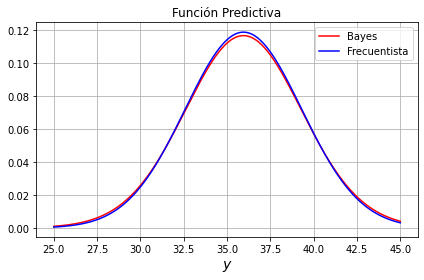

In [24]:
x = np.linspace(25,45,4001)

# Solucion frecuentista
Freq = st.norm(fmean,fstd)

# Plot
fig = plt.figure( figsize=(6,4))
plt.plot(x, y_post.pdf(x), color='r',label='Bayes')
plt.xlabel(r'$y$', fontsize=14)
plt.grid()

plt.plot(x, Freq.pdf(x), color='b',label='Frecuentista')
plt.legend()

plt.title('Función Predictiva')

fig.tight_layout()
plt.show()

La solución que obtuvimos por Bayes es esencialmente la misma a utilizar como predictor una distribución normal con la media y el desvío de la muestra como parámetros. La solución bayesiana (un t-student) le asigna más probabilidad a las colas de la distribución ya que considera la incertidumbre de $\mu$ y $\sigma$ en vez de tomarlos en forma "determinística".

###PASO 4: Evaluación del modelo

Aunque con un único modelo no es posible decir si el modelo es el mejor (no tenemos nada para comparar), como a futuro nos va a interesar hacer comparaciones veamos una de las formas de evaluar distribuciones.

Un QQ-Plot compara los cuántiles (es decir, $x(y) = x\ /\ P(X\leq x ) = y$) entre aquellos de la muestra y los de una distirbución (propuesta o calibrada). Es decir, estamos comparando las inversas de la probablidad acumulada empírica y teórica.

Si las distribuciones coinciden, entonces, todos los puntos caerían en la recta $x=y$, indicando un buen ajuste. Cuando hay diferencias en la simetría, entonces los puntos dejan de parecerse a una recta y empieza a verse una curvatura positiva o negativa (forma cuadrática). Del mismo modo se puede hacer una comparación de la dispersión del modelo vs los datos. Cuando hay diferencias en la dispersión los datos toman forma de $S$. Del mismo modo diferencias en la media (o corrimientos en los resultados) quita a los puntos de la recta pero manteniendo la pendiente y linealidad.

Abajo se puede ver nuestro resultado, pero les recomiendo jugar con distintas distribuciones para tener más feeling de lo que se puede identificar con un qq-plot.

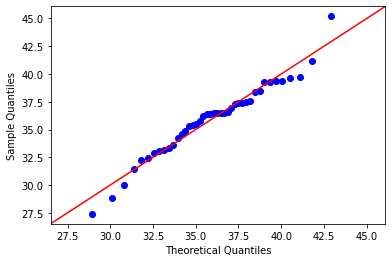

In [42]:
fig = sm.qqplot(df_probetas['Resistencia (MPa)'], dist = y_post, line ='45')

No tenemos mucho para comparar, pero los resultados se ven bien! En clases futuras veremos como evaluar en forma objetiva estos graficos y la bondad del ajuste.

#### Bonus: Comparación con un ajuste Lognormal

En principio no habría que quedarse con un solo modelo, siempre se pueden plantear otros. Por ejemplo, podríamos suponer que los datos fueron generados por una distribución lognormal. Si ese es el caso, entonces el logaritmo natural de los datos siguen una distribución normal:

$$ Log\ y_i \sim N \left( \mu, \sigma^2 \right) $$

Y de ahí en más todo sigue igual al ejercicio anterior. Finalmente podemos volver evaluar la predictora $Log\ \tilde{y}|Log\ \mathbf{y}$ haciendo:

$$p(\tilde{y}|Log\ \mathbf{y}) = \frac{p(Log\ \tilde{y}|Log\ \mathbf{y})}{\tilde{y}}\$$

La tranformación de coordenadas no es particularmente importante, y una vez que empecemos a trabajar con simulación será aún más fácil comparar sin tener que preocuparnos por esto.

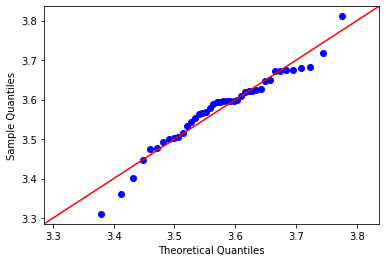

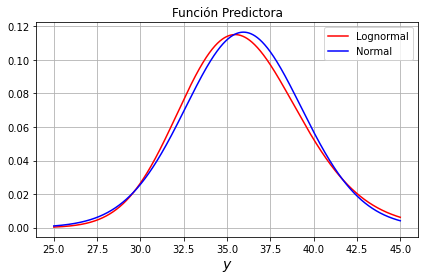

In [43]:
logy = np.log( df_probetas['Resistencia (MPa)'] )
log_fmean = logy.mean()
log_fstd = logy.std()

# Posterior marginal de mu
logmu_post = st.t( N-1, loc=log_fmean, scale=log_fstd*np.sqrt(1/N))

# Posterior marginal de sigma2
logs2_post = st.invgamma( (N-1)/2, loc=0, scale=(N-1)*log_fstd**2/2 )

# Posterior de nuevas observaciones
logy_post = st.t( N-1, loc=log_fmean, scale=log_fstd*np.sqrt(1+1/N))

# qq plot
fig = sm.qqplot( logy, dist = logy_post, line ='45' )

fig = plt.figure()
plt.plot(x, logy_post.pdf(np.log(x))/x, color='r',label='Lognormal')
plt.xlabel(r'$y$', fontsize=14)
plt.grid()

plt.plot(x, y_post.pdf(x), color='b',label='Normal')
plt.legend()

plt.title('Función Predictora')

fig.tight_layout()
plt.show()

Vean que, para este caso, un modelo lognormal también se ajusta bien a los datos, y se parece bastante al modelo normal. Cuál es mejor será una discusión para más adelante.

###PASO 5: Aplicaciones

Con la distribución a posterori (sigamos con el caso Normal) de los parámetros que describen la resistencia característica del hormigón de la planta podemos ya definir la resistencia característica, aquella que tiene un 90% de probabilidad de ser superada.

Cómo traducir este término depende de cuál es nuestro modelo. Si asumimos que valor medio es un valor cierto y que el desvío estandar es el producto de error en la medición, entonces la resistencia característica sería el valor medio tal que la probabilidad de que el valor medio real sea mayor sea del 90%:

$${f^{\prime}}_{c}: x\, /\, P(\mu | \mathbf{y}>x)=0.9$$

Es decir, estamos asumiendo que existe un valor real de la resistencia.

In [44]:
# Resistencia Caracteristica
fprime = mu_post.ppf(0.1)
print('La resistencia característica es', fprime,'MPa')

La resistencia característica es 35.27137673369124 MPa


Para el hormigón elaborado, generalmente que los datos de los ensayos son correctos (NOTA: En relidad 1 ensayo es el promedio de 2/3 probetas) y que no existe UN valor del hormigón ya que no podemos realmente ensayar el mismo hormigón. Lo que nos importa es el ensayo porque asumimos que ese valor es representativo de la resistencia del elemento estructural.

Bajo este último paradigma, entonces la resistencia característica es aquella que **en un futuro ensayo** tiene una probabilidad de 90% de ser superada. Es decir:

$${f^{\prime}}_{c}: x\, /\, P(y | \mathbf{y}>x)=0.9$$

Fijense la diferencia con el caso anterior. No analizo un valor intrínseco del hormigón, sino el resultado que obtengo al ensayarlo. Haciendo esto obtenemos

In [45]:
# Resistencia Caracteristica
fprime2 = y_post.ppf(0.1)
print('La resistencia característica es', fprime2,'MPa')

print('Antes nos dio', fprime,'MPa')

La resistencia característica es 31.513201646505706 MPa
Antes nos dio 35.27137673369124 MPa


La diferencia es bien grande. Por eso es importante tener bien en claro que se está modelando y cuál es el criterio de aceptación. El primer caso se parece más a un Test de Hipótesis (¿puedo decir que el valor medio es mayor a tanto?)

Si utilizamos el CIRSOC 201 (que está basado en considerar una distribución normal) obtenemos:

In [46]:
CIRSOC = fmean - 1.28*fstd
print('Resitencia segun CIRSOC es',CIRSOC,'MPa')

Resitencia segun CIRSOC es 31.640917582475193 MPa


Que es virtualmente idéntico a nuestro segundo paradigma. El valor de 1.28 utilizado arriba es el valor que toma una distribución normal normalizada con probabilidad 0.1:

In [47]:
nor = st.norm(0,1)
k = nor.ppf(0.1)
print(k)

-1.2815515655446004


##Ejemplo 2: Ocurrencia de sismos en la Provincia de San Juan

En el siguiente ejemplo vamos a desarrollar un modelo que explique la ocurrencia de terremetos en San Juan en base a los datos disponibles desde 1941 en USGS.

###PASO 1: Análisis Exploratorio de Datos

Primero, carguemos el archivo tal y como fue extraído de USGS para la provincia de San Juan (para ser precisos, se tomo un rectángulo que aproximademente cubre toda la provincia).

En general se asume que la ocurrencia de sismos sigue una distribución de Poisson. Veamos que obtenemos.

In [48]:
#Abrimos un archivo local, es decir, que ha sido descargado en su computadora
uploaded = files.upload()

Saving Sismos_SanJuan.csv to Sismos_SanJuan.csv


In [49]:
#Se crea un DataFrame
df_sismos = pd.read_csv(io.BytesIO(uploaded['Sismos_SanJuan.csv']))
df_sismos.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2021-12-27T13:01:04.080Z,-31.2940,-69.3336,109.05,4.5,mb,NaN,66.0,0.609,0.77,...,2022-03-05T23:10:45.040Z,"9 km ENE of Calingasta, Argentina",earthquake,4.6,5.8,0.314,3.0,reviewed,us,us
1,2021-12-08T23:36:02.742Z,-31.8741,-68.3598,112.11,4.0,mb,NaN,115.0,0.288,1.04,...,2022-02-12T23:07:04.040Z,"22 km S of Nueve de Julio, Argentina",earthquake,8.2,4.3,0.184,8.0,reviewed,us,us
2,2021-11-25T03:18:30.863Z,-32.7200,-70.1864,112.84,4.0,mb,NaN,109.0,0.310,0.43,...,2022-01-29T22:55:53.040Z,"40 km ENE of Los Andes, Chile",earthquake,2.7,8.1,0.298,3.0,reviewed,us,us
3,2021-11-18T01:09:40.958Z,-31.2685,-69.0364,106.72,4.5,mb,NaN,47.0,0.408,0.65,...,2022-01-22T20:52:00.040Z,"37 km ENE of Calingasta, Argentina",earthquake,5.8,5.4,0.140,15.0,reviewed,us,us
4,2021-11-03T03:17:48.635Z,-32.6971,-70.0638,100.25,5.7,mww,NaN,18.0,0.415,0.77,...,2022-01-14T17:58:56.040Z,Chile-Argentina border region,earthquake,4.6,1.3,0.041,58.0,reviewed,us,us


Para poder agrupar y comparar por año, tenemos que covertir a tipo `datetime` la columna con las fechas de los eventos:

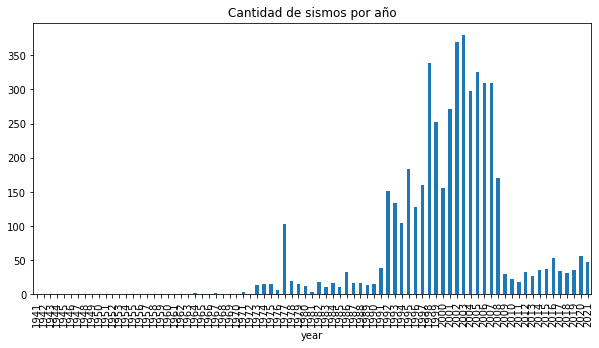

In [51]:
# Convertir a datetime
df_sismos['time'] = pd.to_datetime(df_sismos['time'])

# Conteo por año
Data = df_sismos.groupby(pd.Grouper(key='time', freq='Y')).count().reset_index()
Data['year'] = Data['time'].dt.year

# Grafico
Data.plot(x='year', y='mag',kind='bar', legend=False, figsize=(10,5))
plt.title('Cantidad de sismos por año')
plt.show()

Acá es donde entra en juego el conocmiento del fenómeno físico. Uno ve los datos de arriba y se ven claramente cuatro grandes regiones: Una hasta el 73, otra hasta el 92 y un último quiebre en la información en 2008.

Esto no es porque la sismicidad de San Juan haya cambiado significativamente en estos 50 años, sino que es una consecuencia de los cambios en la instrumentación de la región y los sismos que se informan y recolecta USGS.

Una forma fácil de chequear que el dataset así como está no sigue una distribución de poisson es si $\mu\not=\sigma^2$

In [52]:
# Chequear media y varianza
mu1 = df_sismos['time'].groupby(df_sismos["time"].dt.year).count().mean()
s1 = df_sismos['time'].groupby(df_sismos["time"].dt.year).count().var()
print('media',mu1)
print('varianza',s1)

media 83.10169491525424
varianza 12497.851548801871


No da ni cerca. Entonces, en primer lugar debiéramos filtrar el dataset y quedarnos únicamente con los sismos a partir de 1973 y de magnitud considerable (por ej. mayor a 5.0)

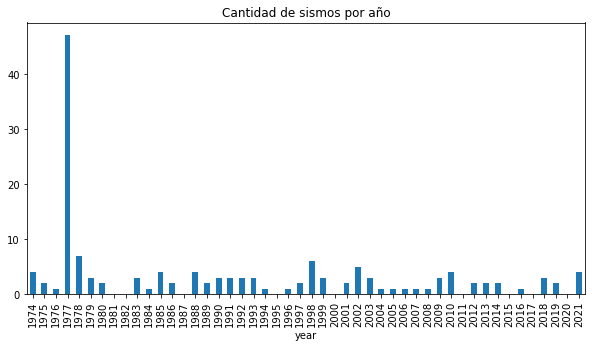

media 3.717948717948718
varianza 52.6288798920378


In [54]:
## Filtrar datos anteriores a 1973 y con M < 5
Filter = (df_sismos['time']>pd.Timestamp('1973-01-01',tz='GMT+0'))*(df_sismos['mag']>5.)
df_sismosF = df_sismos[Filter]

# Conteo por año
Data = df_sismosF.groupby(pd.Grouper(key='time', freq='Y')).count().reset_index()
Data['year'] = Data['time'].dt.year

# Grafico
Data.plot(x='year', y='mag',kind='bar', legend=False, figsize=(10,5))
plt.title('Cantidad de sismos por año')
plt.show()

# Chequear media y varianza
mu1 = df_sismosF['time'].groupby(df_sismosF["time"].dt.year).count().mean()
s1 = df_sismosF['time'].groupby(df_sismosF["time"].dt.year).count().var()
print('media',mu1)
print('varianza',s1)

Los datos ahora son mucho más razonables! Sin embargo hay 1 (o 2) outliers muy claros que rompen con lo que sería un modelo de Poisson. En Noviembre de 1977 ocurrió el sismo de Caucete, uno de los terremotos más destructivos de la historia argentina. Lo que vemos ahí es la enorme cantidad de sismos precedentes y réplicas del sismo de Caucete.

A la hora de modelar la ocurrencia de sismos, estas réplicas deben eliminarse del dataset, ya que lo que sigue una distribución de poisson es el cluster de sismos, no con sus réplicas. Como este no es un curso de análisis sísmico, no entraremos al detalle de como filtrar el dataset, pero pueden encontrarlo en Gardner and Knopoff (1974). En resumen, se mira un ventana espacio-temporal que es función de la magnitud para generar un cluster de sismos, y aquel de mayor magnitud es el evento principal y resto son réplicas, eliminandose del dataset.

**Gardner, J. K., & Knopoff, L. (1974). Is the sequence of earthquakes in Southern California, with aftershocks removed, Poissonian?. Bulletin of the seismological society of America, 64(5), 1363-1367.*

In [55]:
# Gardner Knopoff (1974)

# Distancia en base a latitud y longitud de 2 puntos
def distance_d(LaA, LaB, LoA, LoB):
  # Pasar a Radianes 
  LoA = np.radians(LoA)  
  LoB = np.radians(LoB)  
  LaA= np.radians(LaA)  
  LaB = np.radians(LaB) 
  # "Haversine formula"
  D_Lo = LoB - LoA 
  D_La = LaB - LaA 
  P = np.sin(D_La / 2)**2 + np.cos(LaA) * np.cos(LaB) * np.sin(D_Lo / 2)**2   
  Q = 2 * np.arcsin(np.sqrt(P))   
  # Radio de la tierra en km
  R_km = 6371  

  # Distancia en km
  return(Q * R_km)

# Valores de distancia y tiempo limites para chequear eventos
from scipy.interpolate import interp1d
M = np.linspace(2.5,8.0,12)
Tval = np.array([6,11.5,22,42,83,155,290,510,790,915,960,985])
Rval = np.array([19.5,22.5,26,30,35,40,47,54,61,70,81,94])

# Interpolacion lineal para otras magnitudes
Tthre = interp1d(M,Tval)
Rthre = interp1d(M,Rval)

# Inicializar una nueva columna que indique si es Main Shock (1) o no (2)
df_sismos['Main'] = np.zeros(df_sismos.shape[0])
# Iterar sobre los sismos
for i in range(df_sismos.shape[0]):
  # Chequear que no haya sido descartado por otra ventana
  if df_sismos['Main'][i] != 2:
    Mi = df_sismos['mag'][i] # Magnitud del sismo
    Ti = Tthre(Mi) # Ventana de tiempo
    Ri = Rthre(Mi) # Radio a considerar

    # Encontrar todos los sismos dentro de la ventana espacio-temporal
    Time = df_sismos['time'][i] # Dia del sismo i
    DeltaT = df_sismos['time'] - Time # Tiempo entre sismos
    DeltaT = DeltaT.dt.days # Tiempo en dias
    
    # Latitudes y Longitudes
    LaA = df_sismos['latitude'][i]
    LaB = df_sismos['latitude']
    LoA = df_sismos['longitude'][i]
    LoB = df_sismos['longitude']

    # Distancia entre epicentros
    Dist = distance_d(LaA,LaB,LoA,LoB)

    # Sismos a chequear
    FiltCheck = (np.abs(DeltaT)<Ti)*(Dist<Ri)

    # Verificar que califica como Main Shock
    if (Mi>=df_sismos['mag'][FiltCheck]).all() == True:
      # Descartar Cluster
      df_sismos['Main'][FiltCheck] = 2*np.ones(FiltCheck.shape)
      # Definir Main Shock
      df_sismos['Main'][i] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


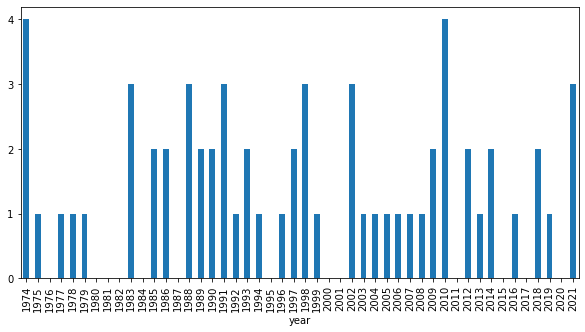

media 1.3125
varianza 1.2832446808510638


In [56]:
# Definir Dataset filtrado final
FinalF = (df_sismos['Main'] == 1)*(df_sismos['mag']>5)*(df_sismos['time']>pd.Timestamp('1973-01-01',tz='GMT+0'))
df_sismosFinal = df_sismos[FinalF]

# Conteo por año
Data = df_sismosFinal.groupby(pd.Grouper(key='time', freq='Y')).count().reset_index()
Data['year'] = Data['time'].dt.year

# Grafico
Data.plot(x='year', y='mag',kind='bar',yticks=[0,1,2,3,4], legend=False, figsize=(10,5))
#plt.title('xx')
plt.show()

# Chequear media y varianza
mu1 = Data['mag'].mean()
s2 = Data['mag'].var()
print('media',mu1)
print('varianza',s2)

Ahora da muchísimo mejor! Ya tenemos un dataset depurado que contiene únicamente los eventos sísmicos principales con magnitud mayor a 5, y la relación media-varianza nos da un buen indicio de que podría seguir una distribución de Poisson. Chequeemos la autocorrelación para asegurarnos que tenemos eventos independientes.

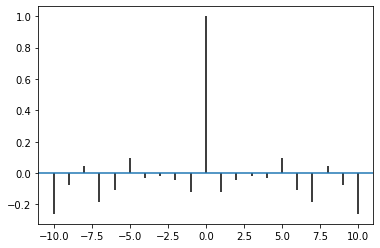

In [58]:
# Autocorrelación
plt.acorr( Data['mag']-Data['mag'].mean() );

### PASO 2: Definición del modelo

En vista de los resultados anteriores, vamos a decir que la cantidad de sismos $y$ en un intervalo $\Delta T$ sigue una distribución de Poisson

$$y \sim Poisson\left(\Delta T\, \lambda\right)$$


Como no tenemos conocimiento previo de la sismicidad de la región, en el ejericio no será una mala idea usar una distribución a priori no-informativa:

$$ p(\lambda) \propto \lambda^{-1}$$

### PASO 3: Inferencia estadística

Considerando esto, la disitrbución a posteriori del parámetro será:

$$\lambda | \mathbf{y} \sim gamma\left(\sum{y_{i}},\frac{1}{\sum{{\Delta T}_{i}}}\right)$$

Donde $\sum{{\Delta T}_{i}}$ es la suma de todas las ventanas de tiempo de los datos y $\sum{y_{i}}$ es la cantidad de eventos registrados.

Finalemente, la función predictiva será

$$\tilde{y} | \mathbf{y} \sim nbinom\left(\Delta T\left(\sum{y_{i}}\right),\frac{1}{\sum{{\Delta T}_{i}}}\right)$$

Resolvamos entonces de dos formas. Primero veamos el ajuste de la distribución de sismos por año ($\Delta T = 1$).

In [59]:
# Numero total de sismos entre 1974 y 2021 con M>5
sumy = Data['mag'].sum()
print('Hubo en total',sumy,'Sismos con M>5')

# Cantidad de años estudiados
sumDT = 2021 - 1974 +1
print('periodo evaluado:',sumDT,'años')
 
# Cantidad de años a considerar
DeltaT = 1
print('ventana:',DeltaT,'años')

# Sismos por año (promedio)
ybar = sumy/sumDT
print('sismos por año:',ybar)

Hubo en total 63 Sismos con M>5
periodo evaluado: 48 años
ventana: 1 años
sismos por año: 1.3125


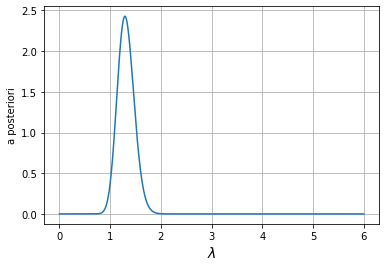

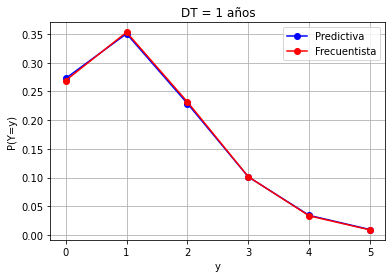

In [62]:
# Inferencia Bayesiana
alpha = 0
beta = 0

# Distribucion a posteriori
aprime = sumy+alpha
bprime = sumDT+beta
lam_post = st.gamma(aprime,scale = 1/bprime)

x = np.linspace(0,6,1001)

# Lambda total
plt.plot(x,lam_post.pdf(x))
plt.xlabel(r'$\lambda$',fontsize=14)
plt.ylabel('a posteriori')
plt.grid()
plt.show()

# Frecuentista
pois = st.poisson(DeltaT*ybar)

# Función predictiva (en el segundo termino va SumDT/(SUMDT+1) )
y_post = st.nbinom(aprime,(bprime/DeltaT)/((bprime/DeltaT)+1))

x2 = np.linspace(0,5,6)
plt.plot(x2,y_post.pmf(x2),'b-o',label='Predictiva')
plt.plot(x2,pois.pmf(x2),'r-o',label='Frecuentista')
plt.grid()
plt.legend(loc=1)
plt.xlabel('y')
plt.ylabel('P(Y=y)')
plt.title('DT = {} años'.format(DeltaT))
plt.show()

Ahora repitamos esto pero si quiero evaluar los resultados en 48 años. Es decir $\Delta T = 48$

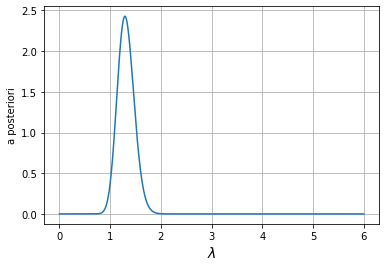

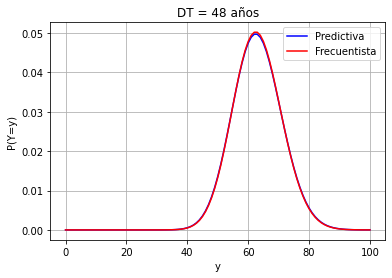

In [64]:
DeltaT = 48

# Inferencia Bayesiana
alpha = 0
beta = 0

# Distribucion a posteriori
aprime = sumy+alpha
bprime = sumDT+beta
lam_post2 = st.gamma(aprime,scale = 1/bprime)

x = np.linspace(0,6,1001)

# Lambda total
plt.plot(x,lam_post.pdf(x))
plt.xlabel(r'$\lambda$',fontsize=14)
plt.ylabel('a posteriori')
plt.grid()
plt.show()

# Frecuentista
pois = st.poisson(DeltaT*ybar)

# Función predictiva
y_post2 = st.nbinom(aprime*DeltaT,(bprime)/((bprime+1)))

x2 = np.linspace(0,100,101)
plt.plot(x2,y_post2.pmf(x2),'b-',label='Predictiva')
plt.plot(x2,pois.pmf(x2),'r-',label='Frecuentista')
plt.grid()
plt.legend(loc=1)
plt.xlabel('y')
plt.ylabel('P(Y=y)')
plt.title('DT = {} años'.format(DeltaT))
plt.show()

Fijense que la distribución a posteriori de $\lambda$ no depende de $\Delta T$, solo importa el número de sismos medidos y el tamaño de la ventana en los que fueron medidos.

En general, a su vez, los resultados coinciden con la solución clásica, con un poco más de peso en las colas al considerar la incertibumbre en el valor de $\lambda$.

###PASO 4: Evaluación

Para variables discretas, la forma más facil de evaluar la aptitud de la función predictiva es comparando el histograma con lo que arroja la función de distribución ajustada, como vimos antes para decir que los datos fueron generados por una distribución de poisson.

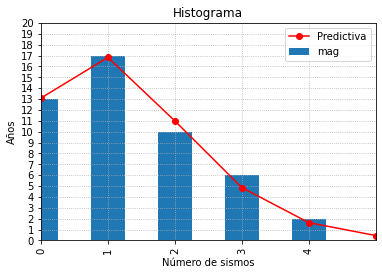

In [ ]:
# Comparacion Grafica
x = np.linspace(0,5,6)
plt.figure()
Data['mag'].value_counts().sort_index().plot(kind='bar')
plt.plot(x,y_post.pmf(x)*sumDT,'r-o',label='Predictiva')
plt.xlim([0,5])
plt.legend(loc=1)
plt.xlabel('Número de sismos')
plt.yticks(np.linspace(0,20,21))
plt.grid(linestyle=':')
plt.ylabel('Años')
plt.title('Histograma')
plt.show()

Se ve claramente que la predictiva se ajusta muy bien a los datos observados.
